# How Anxcor uses XArray to simplify timeseries operations

## Part IV.  Anxcor Processor Class Heirarchy

Up till this point, we've introduced aspects of Anxcor Processor classes, implemented a few of them ourselves, but generally kept the implementation in the realm of pure processing. In this section, we'll dive into the specifics of Anxcor processor classes and show you the range of possibilities for custom functions, as well as the specific contracts your code needs to follow.

### Anxcor Functional Class Design

All of Anxcor's functional classes are designed to 

1) Accept in one or two positional data arguments

2) Accept three keyword-arguments: dask_client, starttime, and station

3) Persist the assumed .attrs metadata attribute between inputs and outputs

4) Allow for asyncronous file IO before or after the processing step

The result is a scheme where ideally you, the implementer, only need to worry about what your function does, not how it's parallelized, what to persist, or any file IO operations. 

As we saw before, all of our processor classes were created by inheriting from XArrayProcessor, or XArrayRolling. There is an additional variant, AnxcorDataTask, that is meant for pure data handling (i.e. combining datasets or initially loading data). All of these inherit from the base class, AnxcorTask, like so:

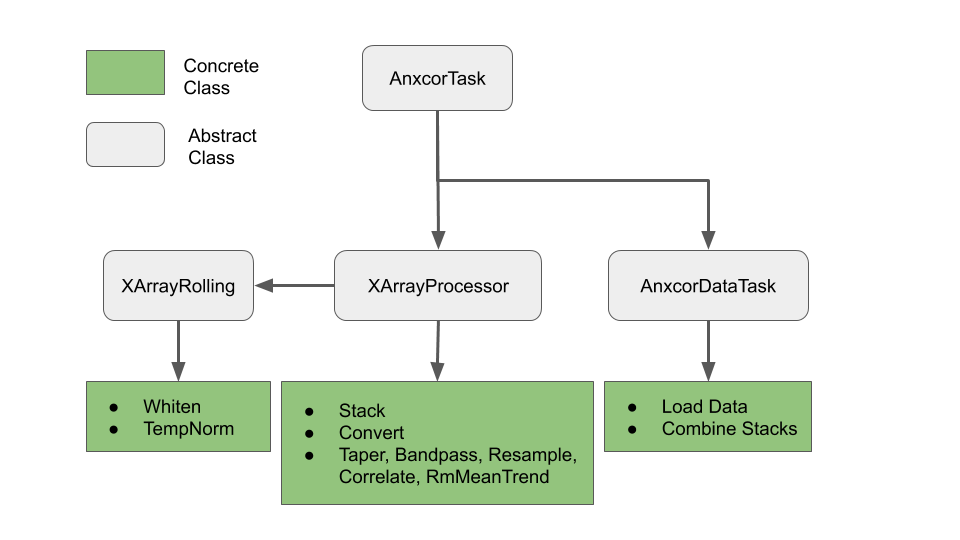

In [2]:
from IPython.display import Image
from IPython.display import display
%matplotlib inline
x = Image(filename='processor_inheritance.png')
display(x)

Each of these has a slightly different control flow specific to the needs of the child implementation. Signal processing implementation aside, lets look at the differences between AnxcorDataTask, and XArrayProcessor

In [6]:
import anxcor.abstractions as abstractions
class XArrayProcessor(abstractions.AnxcorTask):

    def __init__(self,*args,**kwargs):
        super().__init__(*args,**kwargs)

    def _additional_read_processing(self, result):
        if result is not None:
            name   = list(result.data_vars)[0]
            xarray       = result[name].copy()
            xarray.attrs = result.attrs.copy()
            del result
            return xarray
        return result

    def  _should_process(self,xarray, *args):
        return xarray is not None

    def _window_key_convert(self,window):
        return UTCDateTime(int(window*100)/100).isoformat()
    
class AnxcorDataTask(abstractions.AnxcorTask):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _additional_read_processing(self, result):
        return result


AttributeError: module 'anxcor.abstractions' has no attribute 'AnxcorTask'

In [10]:
import inspect
import anxcor
inspect.getmembers(anxcor.abstractions)

[('UTCDateTime', obspy.core.utcdatetime.UTCDateTime),
 ('XArrayProcessor', anxcor.abstractions.XArrayProcessor),
 ('XDatasetProcessor', anxcor.abstractions.XDatasetProcessor),
 ('_IO', anxcor.abstractions._IO),
 ('_XArrayRead', anxcor.abstractions._XArrayRead),
 ('_XArrayWrite', anxcor.abstractions._XArrayWrite),
 ('_XDaskTask', anxcor.abstractions._XDaskTask),
 ('__builtins__',
  {'__name__': 'builtins',
   '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
   '__package__': '',
   '__loader__': _frozen_importlib.BuiltinImporter,
   '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>),
   '__build_class__': <function __build_class__>,
   '__import__': <function __import__>,
   'abs': <function abs(x, /)>,
   'all': <function all(iterable, /)>,
   'any': <function any(iterable, /)>,
   'ascii': <function ascii(obj, /)>,
   'bin': <function bin(number, /)>,
